
image 1/1 C:\Users\Dell\Desktop\Enumerate\pic.jpg: 288x320 1 Tree, 48.9ms
Speed: 1.3ms preprocess, 48.9ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 320)
Land Cover Percentage: 41.78%
Green Cover Percentage: 58.22%


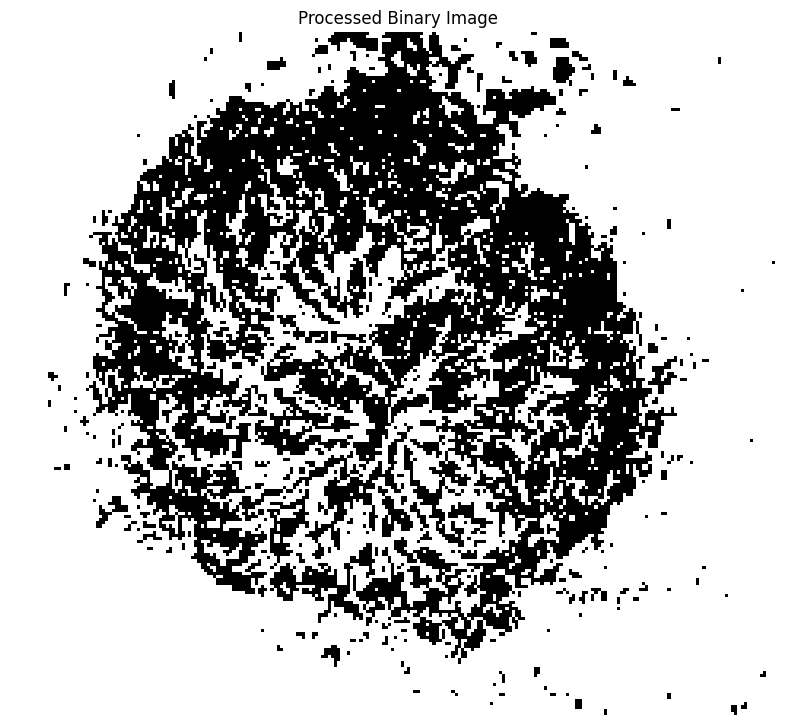

In [39]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

class CoverPercentage:
    def __init__(self, model_path):
        """
        Initialize the CoverPercentage class with the trained YOLO model.
        :param model_path: Path to the trained YOLO model.
        """
        self.model = YOLO(model_path)

    def calculate_cover_percentages(self, image_path):
        """
        Calculate land and green cover percentages.
        :param image_path: Path to the input image.
        :return: A dictionary with land and green cover percentages.
        """
        # Load the image
        image = cv2.imread(image_path)
        height, width, _ = image.shape
        total_pixels = height * width

        # Perform prediction using YOLO model
        results = self.model.predict(source=image_path, device='cpu', save=False)

        # Create a binary mask for detected trees
        binary_mask = np.zeros((height, width), dtype=np.uint8)

        for box in results[0].boxes:
            # Extract bounding box coordinates
            x_min, y_min, x_max, y_max = box.xyxy[0].tolist()
            x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])

            # Mark the detected tree area in the binary mask
            binary_mask[y_min:y_max, x_min:x_max] = 255

        # Calculate green cover percentage (tree area)
        tree_pixels = np.sum(binary_mask == 255)
        green_cover_percentage = (tree_pixels / total_pixels) * 100

        # Calculate land cover percentage (remaining area)
        land_cover_percentage = 100 - green_cover_percentage

        return {
            "land_cover_percentage": land_cover_percentage,
            "green_cover_percentage": green_cover_percentage,
            "binary_mask": binary_mask,
        }

    def convert_image(self, image_path):
        """
        Convert the input image to a black and white binary image.
        :param image_path: Path to the input image.
        :return: Processed black and white image array.
        """
        # Load the image in grayscale directly
        gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Apply thresholding to create a binary image
        _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
    
        return binary_image


# Main Code to Process pic.jpg
if __name__ == "__main__":
    # Paths for model and image
    model_path = r"C:\Users\Dell\runs\detect\train10\weights\best.pt"
    image_path = r"C:\Users\Dell\Desktop\Enumerate\pic.jpg"

    # Initialize and calculate
    cover_calc = CoverPercentage(model_path)

    # Land and tree cover calculations
    results = cover_calc.calculate_cover_percentages(image_path)
    print(f"Land Cover Percentage: {results['land_cover_percentage']:.2f}%")
    print(f"Green Cover Percentage: {results['green_cover_percentage']:.2f}%")

    # Image conversion
    processed_image = cover_calc.convert_image(image_path)

    # Display the processed binary image
    plt.figure(figsize=(10, 10))
    plt.title("Processed Binary Image")
    plt.imshow(processed_image, cmap="gray")  # Ensure the 'gray' colormap is used
    plt.axis("off")
    plt.show()

    # Save the processed binary image
    processed_image_path = image_path.replace(".jpg", "_processed.jpg")
    cv2.imwrite(processed_image_path, processed_image)